In [10]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import importlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output # Only for iPython

import objective as obj
import helper as help
import parameters as param 

from model import WormModel
from contraction import ContractionEngine

importlib.reload(obj)
importlib.reload(help)
importlib.reload(param)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of model failed: Traceback (most recent call last):
  File "c:\Users\natha\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\natha\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "c:\Users\natha\anaconda3\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "c:\Users\natha\anaconda3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "c:\Users\natha\Desktop\UCLA\_Grad\2025-2026\FALL 2025\MAE 263F\MAE-263F\final_report\model.py", line 3, in <module>
    from parameters import param
ImportError: cannot import name 'param' from 'parameters' (c

<module 'parameters' from 'c:\\Users\\natha\\Desktop\\UCLA\\_Grad\\2025-2026\\FALL 2025\\MAE 263F\\MAE-263F\\final_report\\parameters.py'>

In [11]:
maximum_iter = 1000 # Maximum number of iterations
dt = 0.01 # Time step # second
totalTime = 50 # Total time # second

# Variables related to plotting
saveImage = 0 # Set to 1 to save images
plotStep = 250 # Every 5-th step will be plotted

[autoreload of model failed: Traceback (most recent call last):
  File "c:\Users\natha\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\natha\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "c:\Users\natha\anaconda3\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "c:\Users\natha\anaconda3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "c:\Users\natha\Desktop\UCLA\_Grad\2025-2026\FALL 2025\MAE 263F\MAE-263F\final_report\model.py", line 3, in <module>
    from parameters import param
ImportError: cannot import name 'param' from 'parameters' (c

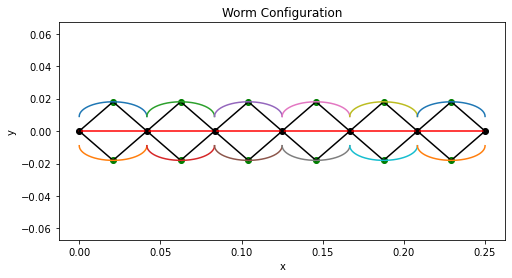

Number of nodes (nv):  19
Number of edges (ne):  30
Number of DOFs (ndof):  38


In [12]:
worm = WormModel(param.length, n_segments=param.n)
worm.plot()

print("Number of nodes (nv): ", worm.nv)
print("Number of edges (ne): ", worm.ne)
print("Number of DOFs (ndof): ", worm.ndof)

## Fixed and Free DOFs

In [13]:
all_DOFs = np.arange(worm.ndof) # Set of all DOFs
fixed_index = np.array([ ]) # Fixed DOFs
free_index = np.setdiff1d(all_DOFs, fixed_index) # All the DOFs are free except the fixed ones

In [14]:
def getFreeIndex(isFixed, worm):
  # isFixed is a 0 or 1 vector of size nv
  # free_index is the output of size ndof = 2 * nv
  worm.nv = len(isFixed) # Number of vertices
  ndof = 2 * worm.nv
  all_DOFs = np.zeros(worm.ndof) # Set of all DOFs -- all DOFs are free

  # Hard code the clamp condition
  all_DOFs[0:4] = 1 # Fix the x-coordinate (left wall)

  for k in range(worm.nv):
    if isFixed[k] == 1:
      # all_DOFs[2*k] = 1
      all_DOFs[2*k+1] = 1 # Fix the y-coordinate (ground)
  free_index = np.where(all_DOFs == 0)[0]
  return free_index

In [ ]:
isFixed = np.zeros(worm.nv)
isFixed[0:2] = 1 # Fix first two nodes
free_index = getFreeIndex(isFixed, worm)
print(free_index)

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37]


## Time Stepping Main Loop

In [ ]:
# Initial conditions
q0 = np.zeros(2 * worm.nv)
for c in range(worm.nv):
  q0[2*c] = worm.nodes[c, 0] # x coordinate
  q0[2*c+1] = worm.nodes[c, 1] # y coordinate
u0 = np.zeros(2 * worm.nv) # old velocity

IndexError: index 7 is out of bounds for axis 0 with size 7

In [ ]:
# Number of steps
Nsteps = round( totalTime / dt )
ctime = 0 # Current time

groundPosition = - 0.02 # Location of ground along y axis

# Loop over the time steps
for timeStep in range(1,Nsteps):

  # Predictor step
  q_guess = q0.copy() # Guess solution
  q_new, error, reactionForce = obj.objfun(q_guess, q0, u0, dt, param.tol, maximum_iter, param.m, mMat, param.EI, param.EA, param.W, param.C,
                        worm.deltaL, free_index)
  if error < 0:
    print('Could not converge.')
    break

  # Check if corrector is needed
  needCorrector = False
  for k in range(2, nv): # First two are always fixed
    # Condition 1: if free node, check if it fell under ground?
    if isFixed[k] == 0 and q_new[2*k+1] < groundPosition:
      needCorrector = True
      isFixed[k] = 1
      q_guess[2*k + 1] = groundPosition
    # Condition 2: if k-th node is fixed but has "wrong" (inward normal) reaction force
    elif isFixed[k] == 1 and reactionForce[2*k+1] < 0:
      needCorrector = True
      isFixed[k] = 0

  # Corrector Step
  if needCorrector:
    print('Entering corrector step')
    free_index = getFreeIndex(isFixed, worm)
    q_new, error, reactionForce = obj.objfun(q_guess, q0, u0, dt, param.tol, maximum_iter, param.m, mMat, param.EI, param.EA, param.W, param.C,
                          worm.deltaL, free_index)

  u_new = (q_new - q0) / dt # New velocity

  ctime += dt # Update current time

  q0 = q_new.copy() # New position becomes old position
  u0 = u_new.copy() # New velocity becomes old velocity

  # Plot
  if timeStep % plotStep == 0:
    x_arr = q_new[::2] # q[0], q[2], q[4]
    y_arr = q_new[1::2] # q[1], q[3], q[5]

    h1 = plt.figure(1)
    plt.clf() # Clear current figure
    plt.plot(x_arr, y_arr, 'ko-')
    plt.title(f't={ctime:.4f}s')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.show()